In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [3]:
print("Loading datasets...")
train_df = pd.read_csv('data/train.csv')
valid_df = pd.read_csv('data/valid.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {valid_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading datasets...
Train data shape: (500, 3)
Validation data shape: (100, 3)
Test data shape: (400, 3)


In [4]:
print("\nSample train data:")
print(train_df.head())

print("\nLabel distribution in train data:")
print(train_df['label'].value_counts())


Sample train data:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

Label distribution in train data:
label
negative    192
positive    189
neutral     119
Name: count, dtype: int64


## Text Preprocessing

In [5]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 128

In [6]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    output_mode='int'
)
text_vectorizer.adapt(train_df['text'].values)

In [7]:
X_train = text_vectorizer(train_df['text'].values).numpy()
X_valid = text_vectorizer(valid_df['text'].values).numpy()
X_test = text_vectorizer(test_df['text'].values).numpy()

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_valid = label_encoder.transform(valid_df['label'])
y_test = label_encoder.transform(test_df['label'])

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Number of classes: 3
Classes: ['negative' 'neutral' 'positive']
X_train shape: (500, 100)
y_train shape: (500,)


## Model Building Functions

In [9]:
def create_lstm_model(num_layers=1, units_per_layer=64, bidirectional=False, vocab_size=MAX_VOCAB_SIZE, 
                     embedding_dim=EMBEDDING_DIM, max_length=MAX_SEQUENCE_LENGTH, num_classes=num_classes):

    model = Sequential()
    
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, input_shape=(max_length,)))
    
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1) 
        
        if bidirectional:
            model.add(Bidirectional(LSTM(units_per_layer, return_sequences=return_sequences)))
        else:
            model.add(LSTM(units_per_layer, return_sequences=return_sequences))
        
        model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
def train_model(model, X_train, y_train, X_valid, y_valid, epochs=20, batch_size=32):

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
    return history

In [11]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    
    return macro_f1, y_pred_classes

In [12]:
def plot_training_history(histories, labels, title):

    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label}', linewidth=2)
    plt.title(f'{title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label}', linewidth=2, linestyle='--')
    plt.title(f'{title} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label}', linewidth=2)
    plt.title(f'{title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label}', linewidth=2, linestyle='--')
    plt.title(f'{title} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Experiment

## Experiment 1: Pengaruh Jumlah Layer LSTM


Training model with 1 LSTM layer(s)...
Model summary for 1 layer(s):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,603 (5.07 MB)

 Trainable params: 1,329,603 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3721 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3563 - loss: 1.0726 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3472 - loss: 1.0725 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3573 - loss: 1.0696 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3727 - loss: 1.0721 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3842 - loss: 1.0708 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3635 - loss: 1.0746 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3940 - loss: 1.0713 - val_accuracy: 0.3800 - v

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395,651 (5.32 MB)

 Trainable params: 1,395,651 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.4006 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.3788 - loss: 1.0803 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.3868 - loss: 1.0762 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3886 - loss: 1.0699 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.3918 - loss: 1.0697 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.3816 - loss: 1.0784 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.3696 - loss: 1.0782 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.4168 - loss: 1.0677 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,747 (5.83 MB)

 Trainable params: 1,527,747 (5.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - accuracy: 0.3797 - loss: 1.0952 - val_accuracy: 0.3800 - val_loss: 1.0875
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.3724 - loss: 1.0864 - val_accuracy: 0.3800 - val_loss: 1.0808
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 304ms/step - accuracy: 0.4186 - loss: 1.0764 - val_accuracy: 0.3800 - val_loss: 1.0778
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.3887 - loss: 1.0699 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.4202 - loss: 1.0685 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.3734 - loss: 1.0751 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.4009 - loss: 1.0674 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.4064 - loss: 1.0728 - val_accuracy: 0

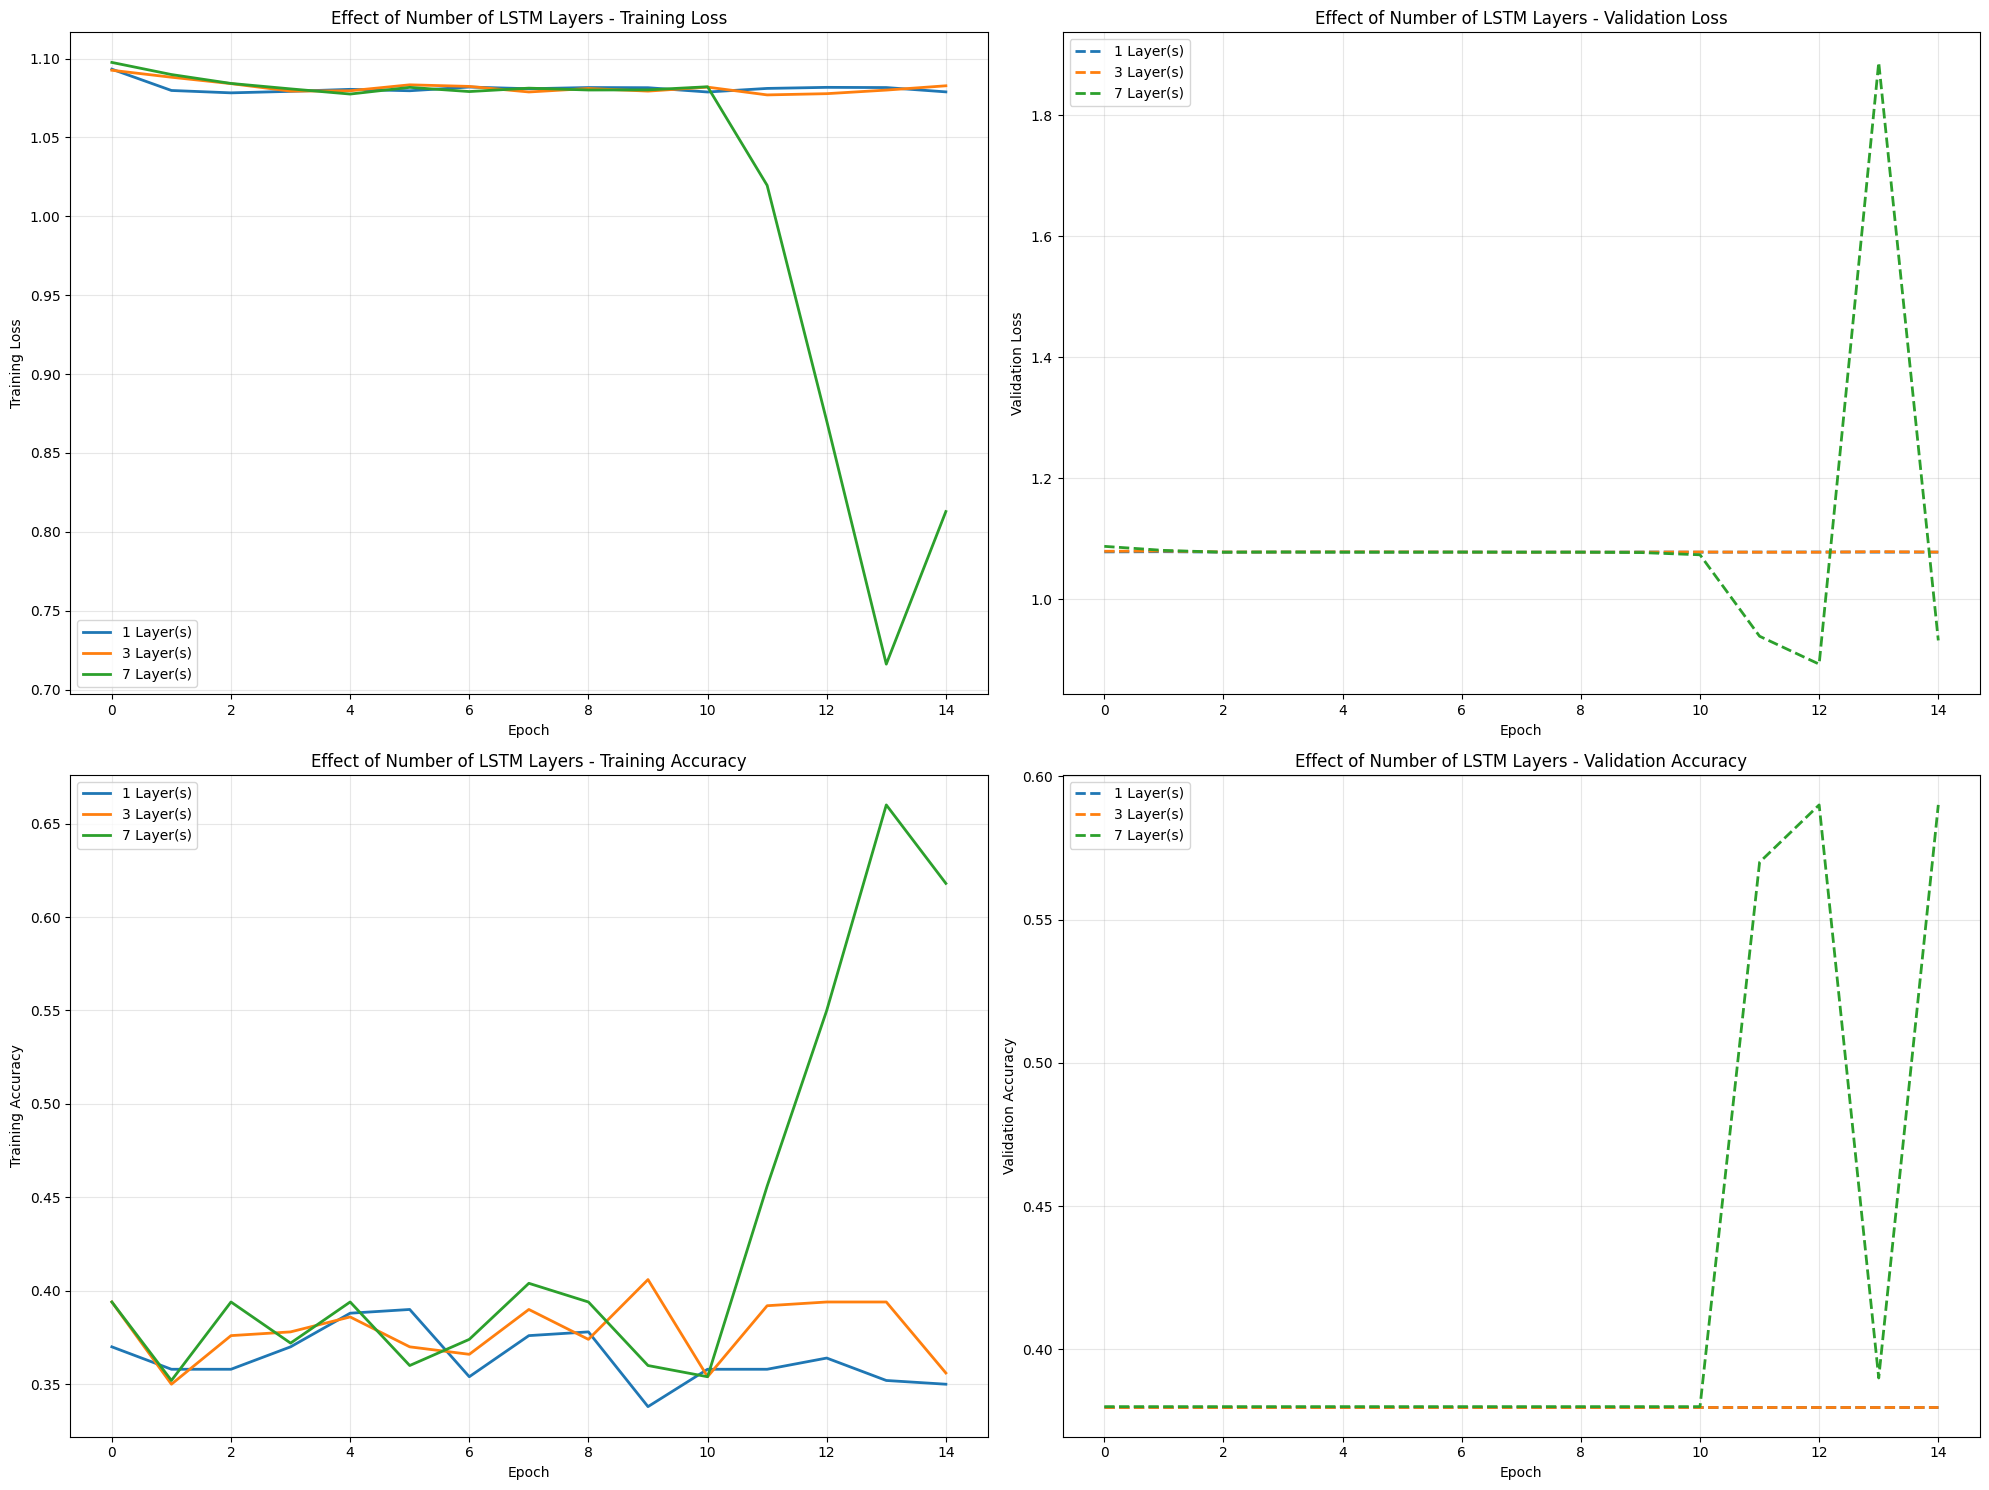

1 Layer(s): Macro F1-Score = 0.1844
3 Layer(s): Macro F1-Score = 0.1827
7 Layer(s): Macro F1-Score = 0.4261


In [13]:
layer_variations = [1, 3, 7]
layer_results = {}
layer_histories = []
layer_labels = []

for num_layers in layer_variations:
    print(f"\nTraining model with {num_layers} LSTM layer(s)...")
    
    model = create_lstm_model(num_layers=num_layers, units_per_layer=64)
    print(f"Model summary for {num_layers} layer(s):")
    model.summary()
    
    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    layer_results[num_layers] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    layer_histories.append(history)
    layer_labels.append(f'{num_layers} Layer(s)')
    
    print(f"Macro F1-Score for {num_layers} layer(s): {macro_f1:.4f}")


plot_training_history(layer_histories, layer_labels, "Effect of Number of LSTM Layers")
for num_layers in layer_variations:
    print(f"{num_layers} Layer(s): Macro F1-Score = {layer_results[num_layers]['macro_f1']:.4f}")

## Experiment 2: Pengaruh Banyak Cell LSTM per Layer


Training model with 32 cells per layer...
Model summary for 32 cells:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100, 32)        │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,309,027 (4.99 MB)

 Trainable params: 1,309,027 (4.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3899 - loss: 1.0893 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4150 - loss: 1.0756 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4317 - loss: 1.0699 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4196 - loss: 1.0730 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3572 - loss: 1.0708 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3881 - loss: 1.0657 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4213 - loss: 1.0709 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3503 - loss: 1.0758 - val_accuracy: 0.3800 - 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,627 (5.20 MB)

 Trainable params: 1,362,627 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.3757 - loss: 1.0896 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3979 - loss: 1.0763 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3564 - loss: 1.0705 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.3545 - loss: 1.0701 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4080 - loss: 1.0709 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3485 - loss: 1.0726 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3684 - loss: 1.0752 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.3890 - loss: 1.0730 - val_accuracy: 0.3800

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,543,555 (5.89 MB)

 Trainable params: 1,543,555 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.3664 - loss: 1.0887 - val_accuracy: 0.3800 - val_loss: 1.0893
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3853 - loss: 1.0877 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.3522 - loss: 1.0716 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3992 - loss: 1.0723 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.4132 - loss: 1.0704 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.4408 - loss: 1.0685 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.4069 - loss: 1.0709 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3659 - loss: 1.0671 - val_accuracy: 0.

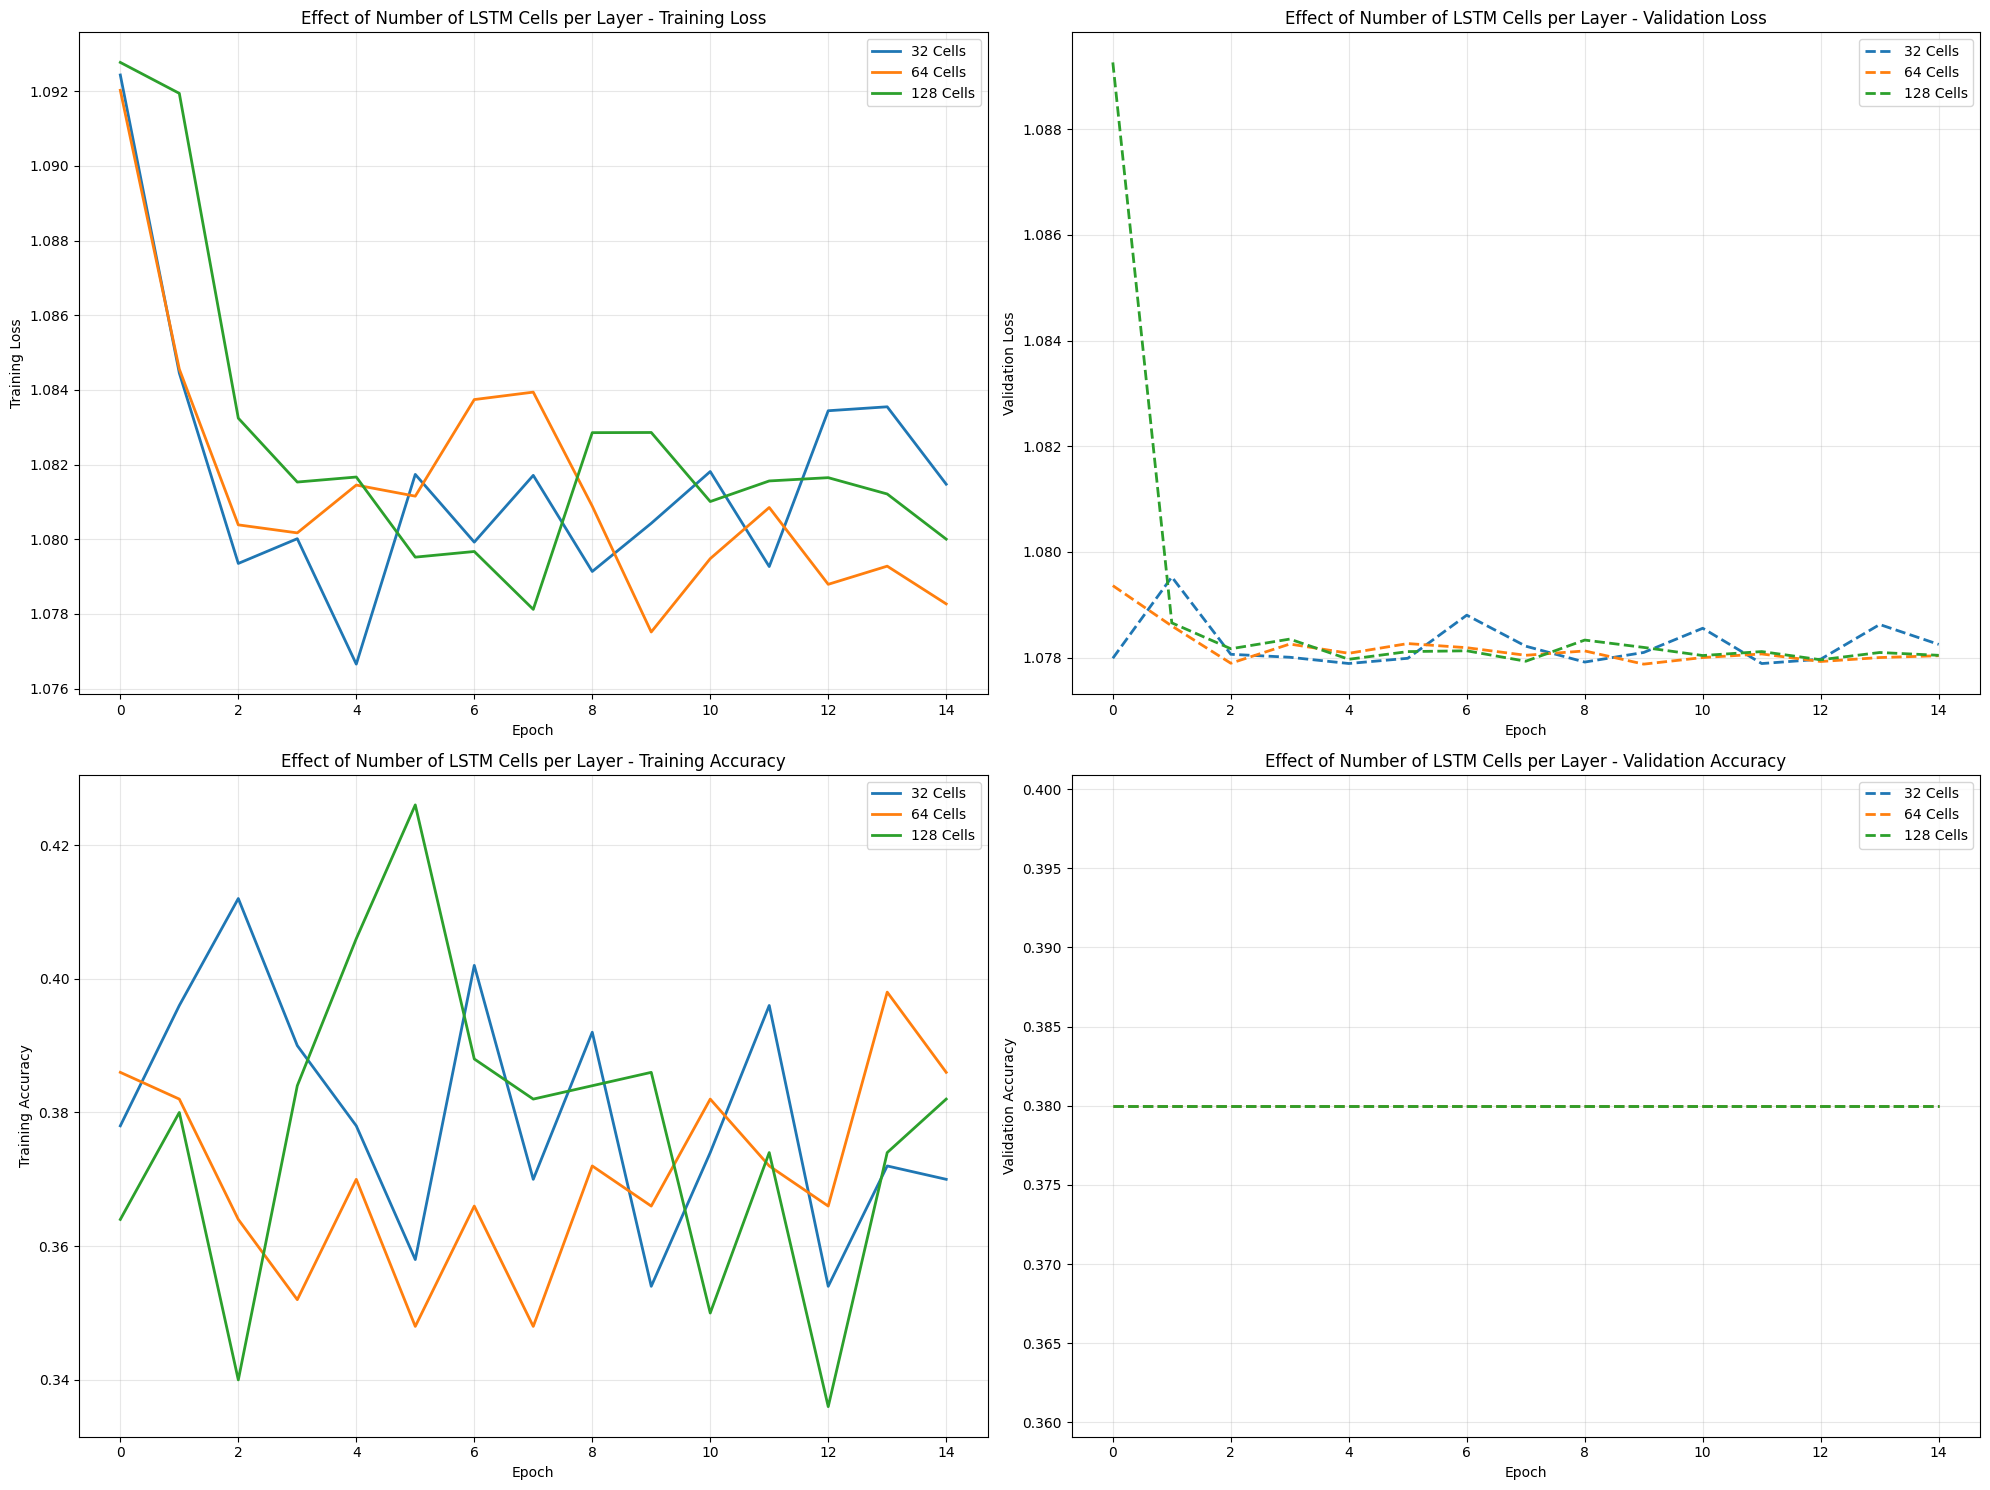

32 Cells: Macro F1-Score = 0.1844
64 Cells: Macro F1-Score = 0.1844
128 Cells: Macro F1-Score = 0.1844


In [14]:
cell_variations = [32, 64, 128]
cell_results = {}
cell_histories = []
cell_labels = []

for num_cells in cell_variations:
    print(f"\nTraining model with {num_cells} cells per layer...")

    model = create_lstm_model(num_layers=2, units_per_layer=num_cells)
    print(f"Model summary for {num_cells} cells:")
    model.summary()
    
    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    cell_results[num_cells] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    cell_histories.append(history)
    cell_labels.append(f'{num_cells} Cells')
    
    print(f"Macro F1-Score for {num_cells} cells: {macro_f1:.4f}")

plot_training_history(cell_histories, cell_labels, "Effect of Number of LSTM Cells per Layer")
for num_cells in cell_variations:
    print(f"{num_cells} Cells: Macro F1-Score = {cell_results[num_cells]['macro_f1']:.4f}")

## Experiment 3: Pengaruh Jenis Layer LSTM Berdasarkan Arah


Training Bidirectional LSTM model...
Model summary for Bidirectional LSTM:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,478,019 (5.64 MB)

 Trainable params: 1,478,019 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.4253 - loss: 1.0679 - val_accuracy: 0.4600 - val_loss: 1.0195
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5224 - loss: 0.9214 - val_accuracy: 0.6000 - val_loss: 0.8716
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6894 - loss: 0.6575 - val_accuracy: 0.6600 - val_loss: 0.7677
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8098 - loss: 0.4099 - val_accuracy: 0.7100 - val_loss: 0.7920
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9540 - loss: 0.1709 - val_accuracy: 0.7000 - val_loss: 0.9097
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9791 - loss: 0.0651 - val_accuracy: 0.7700 - val_loss: 0.8793
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9927 - loss: 0.0232 - val_accuracy: 0.7500 - val_loss: 0.9476
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,627 (5.20 MB)

 Trainable params: 1,362,627 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.3718 - loss: 1.0845 - val_accuracy: 0.3800 - val_loss: 1.0811
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3813 - loss: 1.0795 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3948 - loss: 1.0730 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4448 - loss: 1.0684 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.3927 - loss: 1.0710 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3459 - loss: 1.0796 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3638 - loss: 1.0745 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4032 - loss: 1.0704 - val_accuracy: 0.3

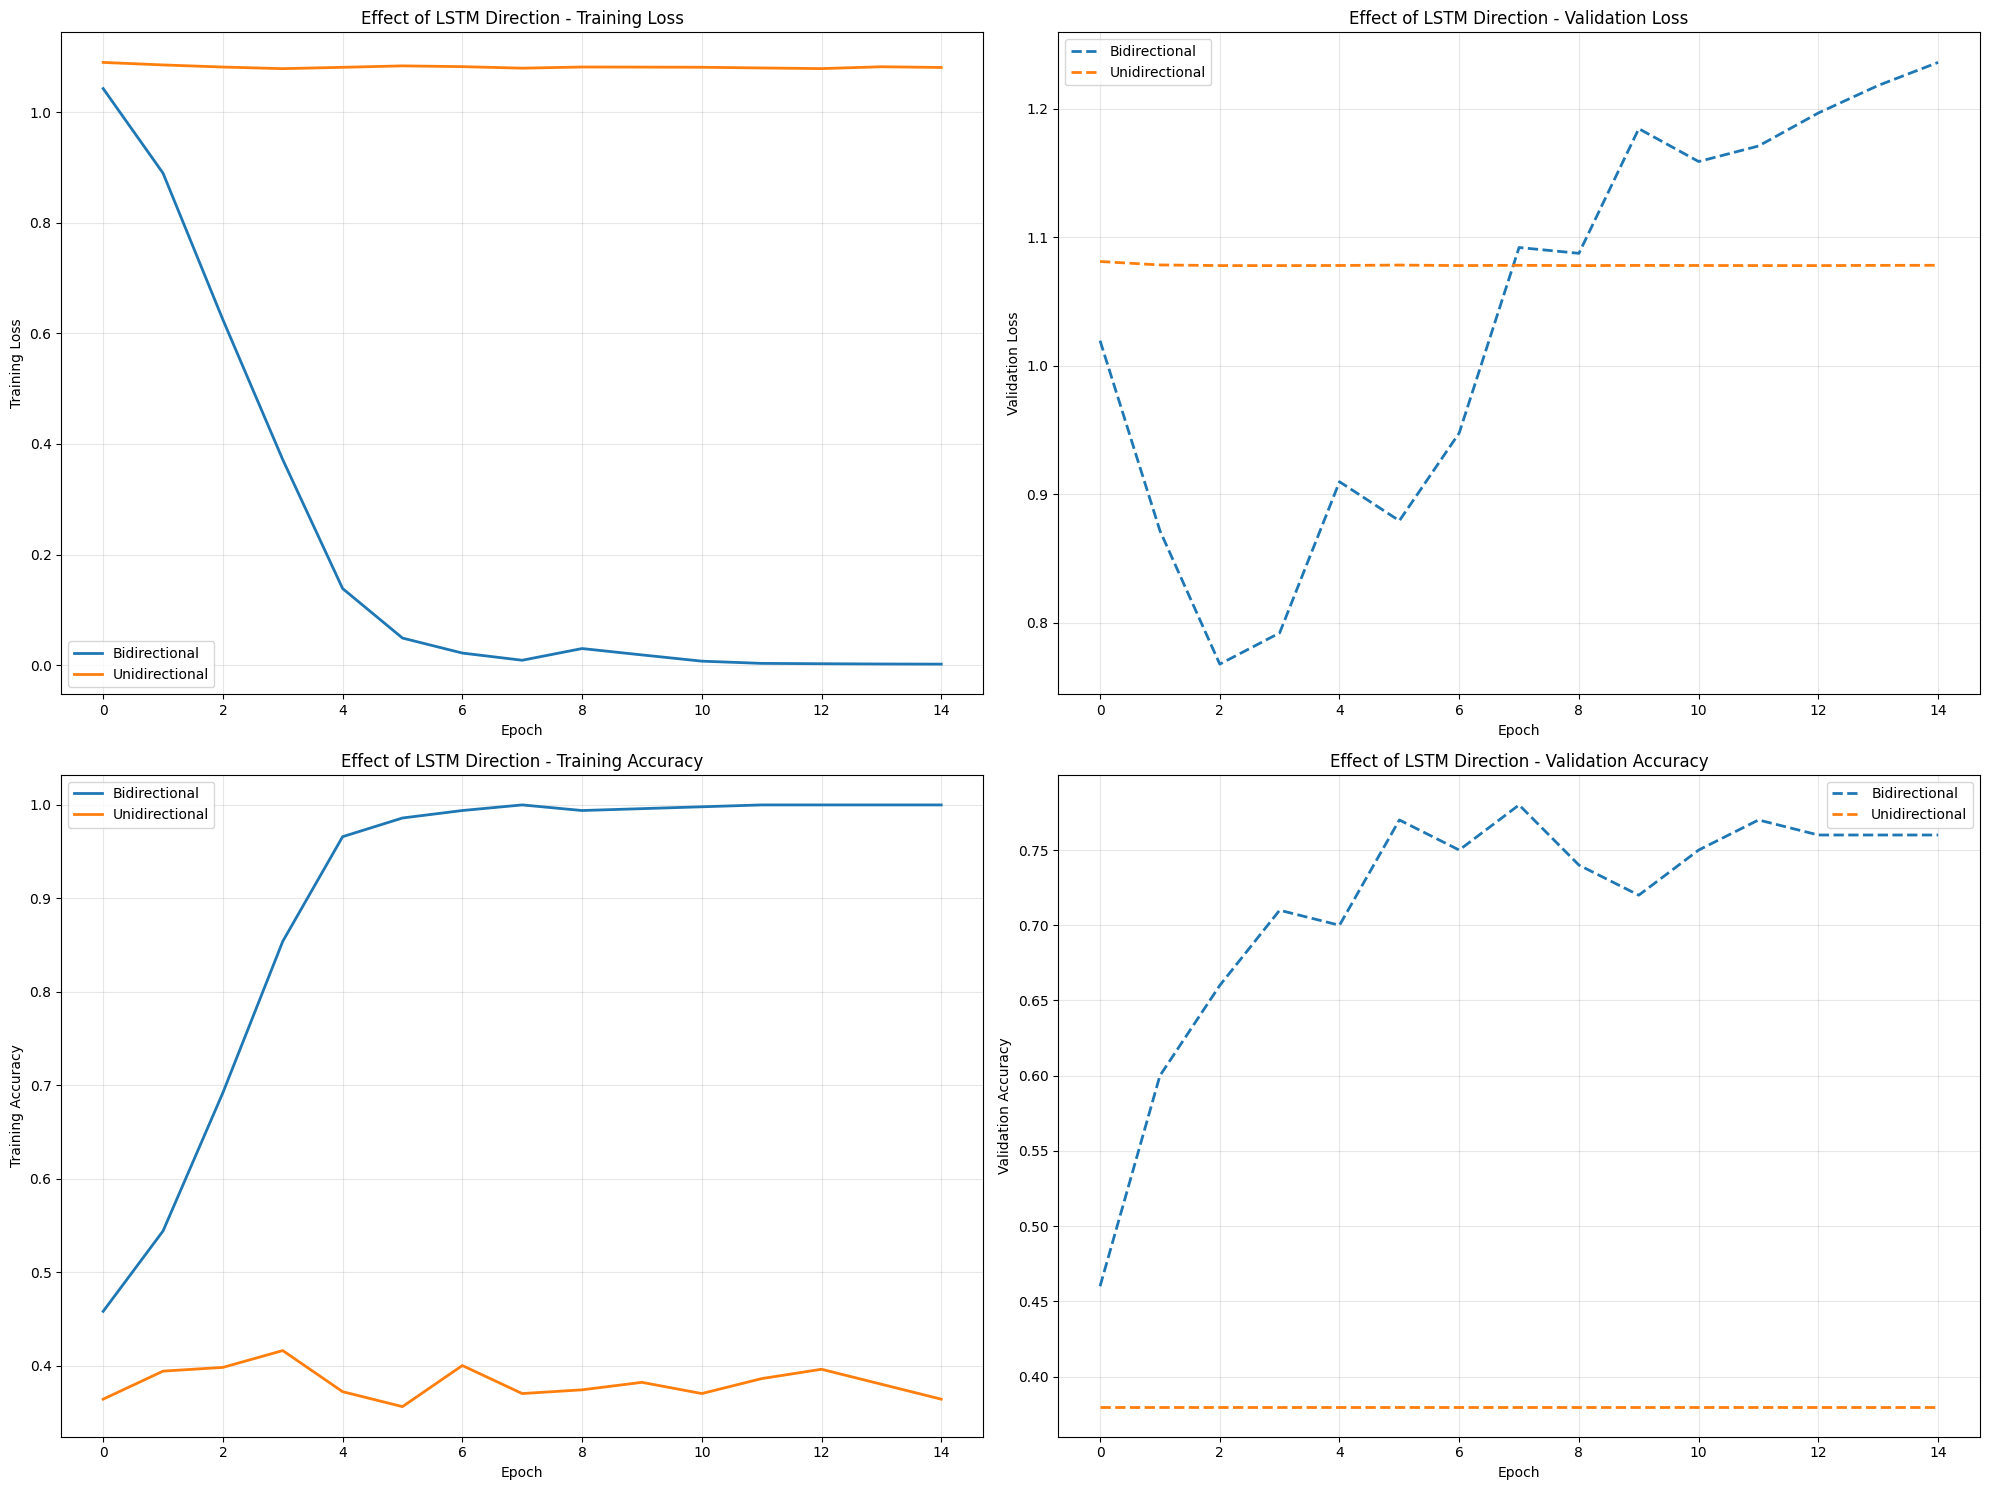

Bidirectional: Macro F1-Score = 0.7401
Unidirectional: Macro F1-Score = 0.1844


In [15]:
direction_variations = [True, False] 
direction_labels_map = {False: 'Unidirectional', True: 'Bidirectional'}
direction_results = {}
direction_histories = []
direction_labels = []

for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    print(f"\nTraining {direction_name} LSTM model...")
    
    model = create_lstm_model(num_layers=2, units_per_layer=64, bidirectional=bidirectional)
    print(f"Model summary for {direction_name} LSTM:")
    model.summary()

    history = train_model(model, X_train, y_train, X_valid, y_valid, epochs=15)
    macro_f1, y_pred = evaluate_model(model, X_test, y_test)

    direction_results[bidirectional] = {
        'model': model,
        'history': history,
        'macro_f1': macro_f1,
        'predictions': y_pred
    }
    
    direction_histories.append(history)
    direction_labels.append(direction_name)
    
    print(f"Macro F1-Score for {direction_name}: {macro_f1:.4f}")

plot_training_history(direction_histories, direction_labels, "Effect of LSTM Direction")
for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    print(f"{direction_name}: Macro F1-Score = {direction_results[bidirectional]['macro_f1']:.4f}")

## Summary

In [16]:
print("\n1. PENGARUH JUMLAH LAYER LSTM:")
best_layers = max(layer_results.keys(), key=lambda x: layer_results[x]['macro_f1'])
for num_layers in layer_variations:
    f1_score = layer_results[num_layers]['macro_f1']
    print(f"   {num_layers} Layer(s): {f1_score:.4f}" + (" -- BEST" if num_layers == best_layers else ""))

print("\n2. PENGARUH BANYAK CELL LSTM PER LAYER:")
best_cells = max(cell_results.keys(), key=lambda x: cell_results[x]['macro_f1'])
for num_cells in cell_variations:
    f1_score = cell_results[num_cells]['macro_f1']
    print(f"   {num_cells} Cells: {f1_score:.4f}" + (" -- BEST" if num_cells == best_cells else ""))

print("\n3. PENGARUH JENIS LAYER LSTM BERDASARKAN ARAH:")
best_direction = max(direction_results.keys(), key=lambda x: direction_results[x]['macro_f1'])
for bidirectional in direction_variations:
    direction_name = direction_labels_map[bidirectional]
    f1_score = direction_results[bidirectional]['macro_f1']
    print(f"   {direction_name}: {f1_score:.4f}" + (" -- BEST" if bidirectional == best_direction else ""))


1. PENGARUH JUMLAH LAYER LSTM:
   1 Layer(s): 0.1844
   3 Layer(s): 0.1827
   7 Layer(s): 0.4261 -- BEST

2. PENGARUH BANYAK CELL LSTM PER LAYER:
   32 Cells: 0.1844 -- BEST
   64 Cells: 0.1844
   128 Cells: 0.1844

3. PENGARUH JENIS LAYER LSTM BERDASARKAN ARAH:
   Bidirectional: 0.7401 -- BEST
   Unidirectional: 0.1844
